In [14]:
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
from selenobot.embedders import AacEmbedder


%load_ext autoreload
%autoreload 2

VAL_DIR = os.path.join('..', 'data', 'validation')

# # Fix the partial columns in the embedding file, which got converted to floats. 
# store = pd.HDFStore('../data/validation/bac120_proteins_r207_subset_max_length_2000.h5', 'r+')
# metadata_df = store.get('metadata')
# partial = pd.read_csv('../data/validation/bac120_proteins_r207_subset_max_length_2000.csv', index_col=0, usecols=['gene_id', 'partial'], dtype={'partial':str})
# metadata_df = metadata_df.drop(columns=['partial']).merge(partial, left_index=True, right_index=True)
# metadata_df.index.name = 'gene_id'
# store.put('metadata', metadata_df, format='fixed')
# store.close()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
feature_types = ['plm', 'aac', 'len']

# Read in the original metadata file, might be useful. 
gtdb_df = pd.read_csv(os.path.join(VAL_DIR, 'bac120_proteins_r207_subset_max_length_2000.csv'), index_col=0, dtype={'partial':str}) 

gtdb_results = {}
for feature_type in feature_types:
    gtdb_results[feature_type] =  pd.read_csv(os.path.join(VAL_DIR, f'bac120_proteins_r207_subset_max_length_2000_predictions_binary_model_{feature_type}.csv'), index_col=0)

# In reading and writing the GTDB data, the partial column got converted back to a float, where it should be a string. 
for feature_type, df in gtdb_results.items():
    df = df.drop(columns='partial').merge(gtdb_df.partial, left_index=True, right_index=True)
    gtdb_results[feature_type] = df

In [10]:
for feature_type, df in gtdb_results.items():
    print(f'Fraction of predicted selenoproteins in GTDB subset ({feature_type}):', df.prediction.sum() / len(df))

Fraction of predicted selenoproteins in GTDB subset (plm): 0.05751118966377822
Fraction of predicted selenoproteins in GTDB subset (aac): 0.2918640711556243
Fraction of predicted selenoproteins in GTDB subset (len): 0.3193247743656463


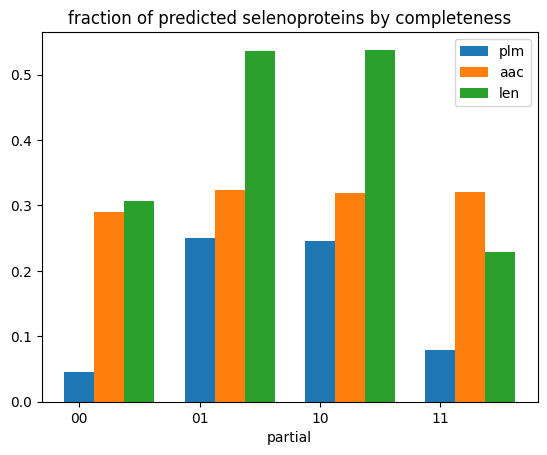

In [45]:
# I am curious if partial sequences are predicted to be truncated with higher frequency than non-partial... 
fig, ax = plt.subplots()

x = np.arange(1, 5)
labels = ['00', '01', '10', '11']
width = 0.25 # The width of the bars. 
legend = []

i = 1
for feature_type, df in gtdb_results.items():
    heights = np.array([df.prediction[df.partial == label].sum() / len(df[df.partial == label]) for label in labels])
    ax.bar(x + (width * i), heights, width=width)
    i += 1
    legend.append(feature_type)

ax.set_xticks(x + width, labels)
ax.set_xticklabels(labels)

ax.set_xlabel('partial')
ax.set_title('fraction of predicted selenoproteins by completeness')
ax.legend(legend)

plt.show()

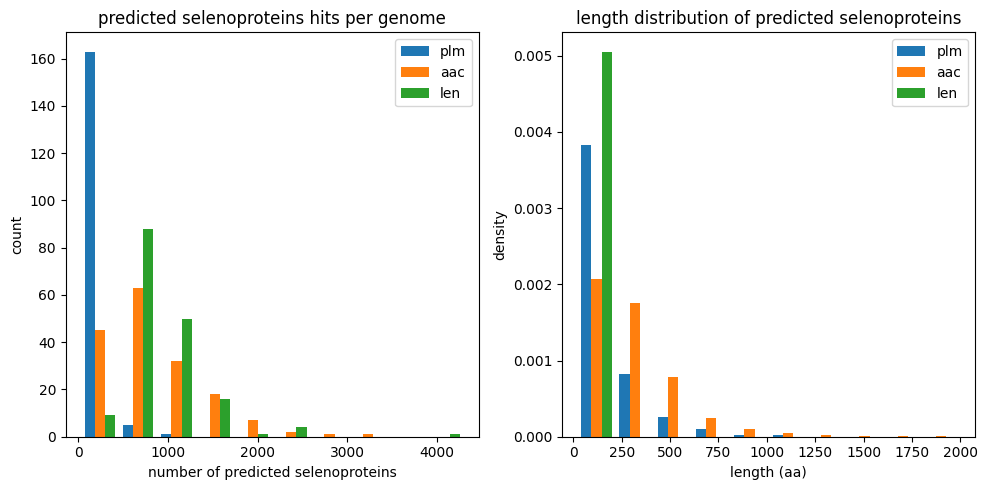

In [46]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

hits_per_genome = []
length_distribution = []
legend = []

for feature_type, df in gtdb_results.items():
    hits_per_genome.append(df[df.prediction == 1].groupby('genome_id').apply(len, include_groups=False))
    length_distribution.append(df[df.prediction == 1].length)
    legend.append(feature_type)
    
axes[0].hist(hits_per_genome)
axes[0].set_xlabel('number of predicted selenoproteins')
axes[0].set_ylabel('count')
axes[0].set_title('predicted selenoproteins hits per genome')
axes[0].legend(legend)

# length_distribution.append(gtdb_results['plm'].length) # Add the background length distribution. 
axes[1].hist(length_distribution, density=True) # , color=['tab:blue', 'tab:orange', 'tab:green', 'gray'])

axes[1].set_xlabel('length (aa)')
axes[1].set_ylabel('density')
axes[1].set_title('length distribution of predicted selenoproteins')
axes[1].legend(legend) #  + ['background'])

plt.tight_layout()
plt.show()

In [ ]:
# I am a bit curious about what signals the amino acid composition-based classifier is picking up on. 
aac_embeddings = pd.read_hdf(os.path.join(VAL_DIR, 'bac120_proteins_r207_subset_max_length_2000.h5'), key='aac')
aac_embeddings = aac_embeddings.rename(columns={val:key for key, val in AacEmbedder.aa_to_int_map.items()})
# TODO: Should replace these with model outputs. 
aac_embeddings['plm_prediction'] = gtdb_results['plm'].prediction # Indices should be lined up. 
aac_embeddings['aac_prediction'] = gtdb_results['aac'].prediction

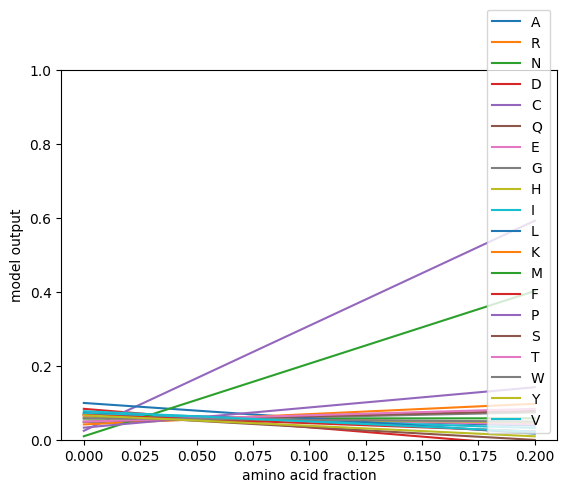

In [43]:
fig, ax = plt.subplots()

feature_type = 'plm'
legend = []
slope_threshold = 0

# min_x = min(aac_embeddings[list(AacEmbedder.aa_to_int_map.keys())].values.ravel())
# max_x = max(aac_embeddings[list(AacEmbedder.aa_to_int_map.keys())].values.ravel()) 
plot_x = np.linspace(0, 0.2, 25)

lines_df = []
for aa in AacEmbedder.aa_to_int_map.keys():
    if aa == 'O': # This is just full of zeros for some reason. 
        continue
    x = aac_embeddings[aa].values 
    y = aac_embeddings[f'{feature_type}_prediction'].values

    m, b = np.polyfit(x, y, 1)
    if abs(m) > slope_threshold:
        ax.plot(plot_x, plot_x * m + b)
        legend.append(aa)
    
    lines_df.append({'aa':aa, 'm':m, 'b':b})

lines_df = pd.DataFrame(lines_df).set_index('aa')

ax.set_ylim(0, 1)
ax.set_xlabel('amino acid fraction')
ax.set_ylabel('model output')
ax.legend(legend)
plt.show()


In [44]:
lines_df.sort_values('m')

,m,b
aa,,
D,-0.500990,0.083580
L,-0.414781,0.099491
Q,-0.344350,0.068349
Y,-0.285145,0.066216
V,-0.279452,0.077251
F,-0.223221,0.067076
I,-0.192436,0.070189
A,-0.169760,0.072050
E,-0.119102,0.065561


In [36]:
aac_embeddings[list(AacEmbedder.aa_to_int_map.keys())].values

array([[0.18333333, 0.07777778, 0.02777778, ..., 0.        , 0.00555556,
        0.07222222],
       [0.08133971, 0.11483254, 0.05741627, ..., 0.00478469, 0.02392344,
        0.05741627],
       [0.11428571, 0.08571429, 0.05714286, ..., 0.        , 0.02857143,
        0.        ],
       ...,
       [0.01595745, 0.03723404, 0.04787234, ..., 0.0212766 , 0.04787234,
        0.03723404],
       [0.04054054, 0.03716216, 0.08108108, ..., 0.00337838, 0.07432432,
        0.03716216],
       [0.10606061, 0.03030303, 0.04545455, ..., 0.03030303, 0.01515152,
        0.06060606]])